# Global constants

In [1]:
GRAIN_TYPE = 'WheatAdded_Type'
# GRAIN_TYPE = 'Oats'
# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
#GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_1/model_Moisture_Content/' + GRAIN_TYPE + '_t1_dnn_mc.h5'

In [2]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt

#Data Manipulation
import pandas as pd
import numpy as np
import random

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold

print(tf.__version__)
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)



2024-02-23 12:39:39.290555: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-23 12:39:40.058262: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-23 12:39:40.058951: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-23 12:39:40.064222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-23 12:39:40.064318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.63GiB deviceMemoryBandwidth: 938.86GiB/s
2024-02-23 12:39:40.064330: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-02-23 12:39:40.065490: I tensorflow/stream_executor/platform/d

# Helper functions

In [4]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(trueValues, predictions)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

# 1. Load the Dataset
We are going to use one dataset from UCI Machine Learning Repository. You can download the Energy Efficient Dataset using the following link. You can use pandas to download and open the data set which is in excel format or load from your local machine.

In [5]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
#df = df[df['Variety'] == 'SOUTH DAKOTA']
print("From USDA: ", URL)

df.head()

From USDA:  ../Datasets/processed/WheatAdded_Type.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
0,0,KANSAS,7.0,8.9,11.3,0.7356,8.8258,-55.973,-415.973,2.416,0.243,15.855506,-6.341975,62.3,61.7806
1,1,KANSAS,8.0,8.9,11.3,0.7356,10.2572,-114.289,-474.289,2.412,0.246,15.855506,-11.142320,71.2,82.0576
2,2,KANSAS,9.0,8.9,11.3,0.7356,11.5679,-168.171,-528.171,2.395,0.246,15.855506,-14.537729,80.1,104.1111
3,3,KANSAS,10.0,8.9,11.3,0.7356,12.8795,134.849,-585.151,2.390,0.246,15.855506,10.470049,89.0,128.7950
4,4,KANSAS,11.0,8.9,11.3,0.7356,13.7649,83.502,-636.498,2.371,0.238,15.855506,6.066299,97.9,151.4139


# 2. Overview of data


In [6]:
# Data summary
df.describe()

,Unnamed: 0,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn,Freq*d(cm),Freq*Attn
count,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000,806.000000
mean,402.500000,10.811414,7.088834,16.189541,0.796298,18.410033,-4.604663,-633.488065,2.912112,0.499187,16.189541,-0.377074,77.159677,215.799030
std,232.816451,3.530055,1.554604,3.794772,0.067384,5.946835,101.951444,219.510760,0.305758,0.186739,0.629743,6.071761,32.552200,124.108325
min,0.000000,5.000000,4.400000,10.260000,0.625400,8.002300,-179.335000,-1274.435000,2.340000,0.220000,15.352809,-17.418676,22.000000,40.011500
25%,201.250000,8.000000,6.500000,13.680000,0.745400,13.524700,-88.842000,-793.405750,2.688500,0.337000,15.855506,-5.077754,52.800000,107.817375
50%,402.500000,11.000000,7.700000,16.225000,0.801300,18.131600,-9.838500,-602.380500,2.861500,0.470500,16.400366,-0.589378,71.200000,195.600450
75%,603.750000,13.000000,7.700000,18.810000,0.842000,23.098000,80.957250,-456.055750,3.109750,0.639000,16.401988,4.300734,100.100000,310.863000
max,805.000000,18.000000,8.900000,24.410000,0.927800,29.897000,179.048000,-235.044000,4.038000,0.987000,17.344167,14.827701,160.200000,538.146000


In [7]:
# Dimension of the dataset
df.shape

(806, 15)

In [8]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
Type                      0
Phase/Attn                0
Freq*d(cm)                0
Freq*Attn                 0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [9]:
# Convert to numpy array
df_features = df[['Freq',
                    'd(cm)',
                    #'Attn',
                    #'Phase',
                    'Phase_Corr',
                    'Permittivity_real',
                    'Permittivity_imaginary',
                    'Type',
                    #'Density'
            ]]

# df_targets = df[['M%', 'Density']]
df_targets = df[['Density']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()
# learning_rates = [ 0.0008,0.00085,0.0009]
# batch_sizes = [256]
# neurons = [89]
# epochs_options = [140,150]
learning_rates = [ 0.00015,0.0002,0.0003,0.0004,0.0005,0.0006,0.00065,0.0007,0.0008,0.00085,0.0009]
batch_sizes = [8,16,32,64,128,200,256]
neurons = [8, 16, 32, 64, 89]
epochs_options = [140,150,155,160,165,170,175,180]

## Splitting dataset to test and train+validate

In [10]:
# Perform train-test split on RAW DATA
X_trainVal, X_test, y_trainVal, y_test = train_test_split(dataset_x, dataset_y, 
                                                    test_size=0.2
                                                    ,random_state=42
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, 
                                                    test_size=0.15 #validation split
                                                    ,random_state=42
                                                    )

## Normalize datasets

In [11]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize Train set
X_train_norm = scaler_input.fit_transform(X_train)
y_train_norm = scaler_output.fit_transform(y_train)

# Normalize Validation set
X_val_norm = scaler_input.fit_transform(X_val)
y_val_norm = scaler_output.fit_transform(y_val)

# Normalize the test dataset
X_test_norm = scaler_input.transform(X_test)
y_test_norm = scaler_output.transform(y_test)

## Running model with KCV

In [12]:
from sklearn.model_selection import KFold
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.optimizers import Adam
tf.get_logger().setLevel('ERROR') 

K_FOLD_SPLITS = 5
FILENAME_BEST_MODEL = 'best_model.h5'
# Define the cross-validation process
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y = y_train_norm[:,0]
X = X_train_norm
best_params = {
    'learning_rate': None,
    'batch_size': None,
    'neurons': None,
    'activation': None,
    'epochs': None,
    'loss': float('inf')
}
def train_and_evaluate_fold(train_indices, test_indices, epoch, batch, neurons,lr):
    trainX, testX = X[train_indices], X[test_indices]
    trainY, testY = Y[train_indices], Y[test_indices]
    
    # Define your model building function and compile it
    model = Sequential([
        Dense(neurons, activation="relu", input_shape=(6,)),
        Dense(neurons, activation="relu"),
        Dense(neurons, activation="relu"),
        Dense(1, activation='sigmoid')
    ])    
    model.compile(optimizer=Adam(learning_rate=lr),loss='mse')

    # Fit the model
    history = model.fit(trainX, trainY, epochs=epoch, batch_size=batch, validation_data=(testX, testY), verbose = 0)
    
    # Evaluate the model
    loss= model.evaluate(x=testX, y=testY, verbose=0)
    
    # get the max abs error
    pred_mc = model.predict(X_test_norm)
    Y_pred = scaler_output.inverse_transform(pred_mc)
    Y_actual = np.array(y_test)
    #mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
    #print("R^2: {:#.4g}".format(mc_r2_score))
    #mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
    #print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
    #mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
    #print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

    sums = []
    for i in range(len(Y_actual[:,0])):
        sum = Y_actual[:,0][i] - Y_pred[:,0][i]
        #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
        sums.append(abs(sum))
    #print("Min Absolute Error: ",min(sums))
    #print("Max Absolute Error: ",max(sums))

    return loss, history, max(sums)
cv_scores = []
min_loss = float('inf')
best_model = None
history_best_model = None
arr_loss = []
arr_max_abs_err = []
params = [{}]
total_runs = len(learning_rates) * len(batch_sizes) * len(neurons) * len(epochs_options)
current_runs = 0
# Use ThreadPoolExecutor to parallelize the training and evaluation
with ThreadPoolExecutor(max_workers=5) as executor:
    # Submit tasks to the executor
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for neuron_count in neurons:
                for epochs in epochs_options:
                    futures = {executor.submit(train_and_evaluate_fold, train_indices, test_indices,epochs,batch_size,neuron_count,lr): (train_indices, test_indices) for train_indices, test_indices in cv.split(X)}
                    losses = []
                    MaxAbsErrs = []
                    for future in as_completed(futures):
                        loss, history, MaxAbsErr = future.result()
                        losses.append(loss)
                        MaxAbsErrs.append(MaxAbsErr)
                        #print(f"Loss = {loss}, RMSE = {rmse}")
                        
                    arr_loss.append(np.mean(loss))
                    if loss < min_loss:
                        best_params.update({
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'neurons': neuron_count,
                            'epochs': epochs,
                            'loss': loss
                        })
                        print("New model loss: ", loss," Old model: ", min_loss)
                        print("Max Abs ERror: ",np.mean(MaxAbsErrs))
                        arr_max_abs_err.append(np.mean(MaxAbsErr))
                        params.append({
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'neurons': neuron_count,
                            'epochs': epochs,
                            'loss': loss
                        })
                        print(best_params)
                        #best_model = model
                        history_best_model = history
                        min_loss = loss
                    current_runs += 1
                    if current_runs % 25 == 0:
                        print("Run ",current_runs," of ",total_runs,)
    
    #print('Loss array:', arr_loss)

# Saving the best model within the k folds


2024-02-23 12:39:41.543525: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 12:39:41.544875: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-23 12:39:41.545147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-23 12:39:41.545459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.63GiB deviceMemoryBandwidth

New model loss:  0.002147325314581394  Old model:  inf
Max Abs ERror:  1.9598248443603512
{'learning_rate': 0.0008, 'batch_size': 16, 'neurons': 8, 'activation': None, 'epochs': 165, 'loss': 0.002147325314581394}
New model loss:  0.0013974820030853152  Old model:  0.002147325314581394
Max Abs ERror:  1.7951467666625973
{'learning_rate': 0.0008, 'batch_size': 16, 'neurons': 8, 'activation': None, 'epochs': 170, 'loss': 0.0013974820030853152}
New model loss:  0.0011019866215065122  Old model:  0.0013974820030853152
Max Abs ERror:  2.025276576995849
{'learning_rate': 0.0008, 'batch_size': 16, 'neurons': 8, 'activation': None, 'epochs': 174, 'loss': 0.0011019866215065122}
New model loss:  0.0010036525782197714  Old model:  0.0011019866215065122
Max Abs ERror:  1.4112580413818354
{'learning_rate': 0.0008, 'batch_size': 16, 'neurons': 16, 'activation': None, 'epochs': 165, 'loss': 0.0010036525782197714}
New model loss:  0.0008012414909899235  Old model:  0.0010036525782197714
Max Abs ERror: 

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

In [13]:
print(list(history_best_model.history.keys()))

['loss', 'val_loss']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


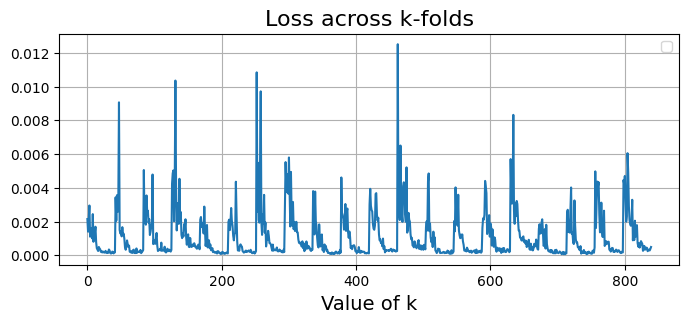

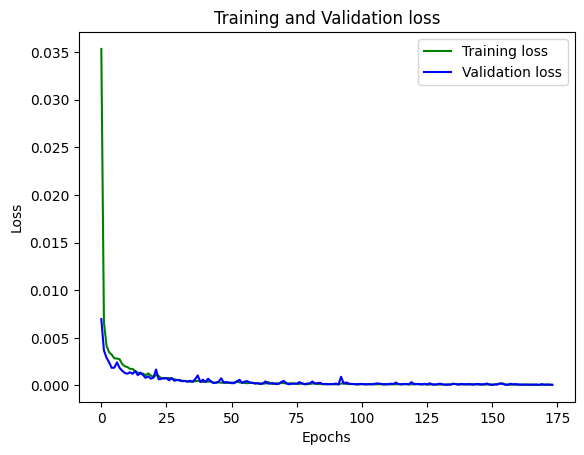

In [14]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

# Training and Validation Loss
plot_loss_curve(history_best_model, best_params["epochs"])

## Prediction on Test Dataset

In [15]:
import time

start_time = time.time()
pred_mc = best_model.predict(X_test_norm)
end_time = time.time()

# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")

Y_pred = scaler_output.inverse_transform(pred_mc)
Y_actual = np.array(y_test)

AttributeError: 'NoneType' object has no attribute 'predict'

## Plotting Real vs Predicted values

Maxval here is:  24.41


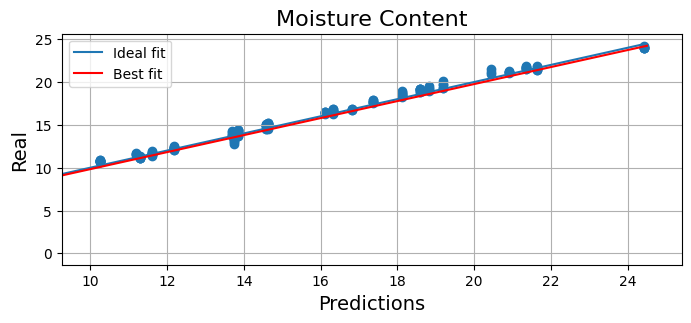

In [ ]:
# MOISTURE CONTENT
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
plt.xlim([min(min(Y_pred[:,0]), min(Y_actual[:,0]))-1, max(max(Y_pred[:,0]), max(Y_actual[:,0]))+1])

a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()

plt.savefig('../Poster/Results/obj_1_MC.svg',
                bbox_inches='tight',
                dpi=300, 
                transparent=True)           

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round

mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.9893
Mean Squared Error:  0.1504
Mean Absolute Error:  0.3233
Min Absolute Error:  0.008487358093262287
Max Absolute Error:  1.070511169433594
